# Finalize atlas

In [1]:
import os
os.chdir("../..")

import pymde
import numpy as np
import pandas as pd
pymde.seed(0)

import scanpy as sc

from Functions import immediate_early_pc, integrate_datasets, process_integration, mde_embedding

Global seed set to 0


<Figure size 72x72 with 0 Axes>

In [2]:
adata = sc.read_h5ad("Output/Data/2-Integration/2-Subset.h5ad")

## Subset
First, clusters are removed if they fall within one of the following criteria:
- "Below_Threshold"
  - Cluster contains less than 5 cell(s) from Xu2020
  - If subclustered, subcluster contained 0 Xu2020 cells 
- "Low_Quality"
  - If subclustered, subcluster is strongly enriched for mito genes 

In [3]:
adata._inplace_subset_obs(adata.obs.annotated != "Below_Threshold")
adata._inplace_subset_obs(adata.obs.annotated != "Low_Quality")

The following clusters are stored seperately, due to absence of markers in ABA ISH
- Tcf7l2-Shox2 (ABA: Tcf7l2)
- Slc32a1-Dlx1 (ABA: Dlx1)
- Trh-Zic1     (ABA: Zic1)

In [4]:
def exclude_nonpvn(adata: sc.AnnData) -> None:
    exclude = ["Tcf7l2-Shox2","Slc32a1-Dlx1","Trh-Zic1"]
    exclude = [x in exclude for x in adata.obs.annotated]
    adata[exclude, :].write_h5ad("Output/Data/2-Integration/3-Excluded.h5ad")
    adata._inplace_subset_obs([not x for x in exclude])

exclude_nonpvn(adata)

## Pre-autonomic Dataset
The Beine *et al.* (2022) traced pre-autonomic neurons are concatenated to the atlas

In [5]:
def add_beine(adata: sc.AnnData) -> sc.AnnData:
    beine = sc.read_h5ad("Output/Data/1-FromRaw/Beine2022.h5ad")
    adata = sc.concat([adata,beine], join = "outer")
    adata.layers["counts"] = adata.X.copy()

    return adata

adata = add_beine(adata)

adata.obs["immediate_early"] = immediate_early_pc(adata)

## Final Integration
Then, the atlas in integrated one last time, to obtained an updated latent representation.  
The C66_named metadata variable was simplified by retaining the 4 most abundant values

In [6]:
print(adata.obs.C66_named.value_counts().head(5))

def simplify_c66(adata: sc.AnnData) -> None:
    include = adata.obs.C66_named.value_counts().head(4).index
    include = np.array(include, dtype = str)
    adata.obs["C66_named"] = [
        x if x in include else pd.NA 
        for x in adata.obs.C66_named
    ]

simplify_c66(adata)

C66-22: Caprin2.GLU-6    1747
C66-4: Trh.GLU-2          841
C66-3: Nxph4.GLU-2        757
C66-5: Tent5a.GLU-2       522
C66-6: Samd3.GLU-2         27
Name: C66_named, dtype: int64


The dataset-corrected variable features were determined and stored for later use in Fig 2B (Heatmap w/ correlations)

In [7]:
def highly_variable(adata: sc.AnnData) -> None:
    # Exclude mitochondrial, ribosomal, and hemoglobin genes
    adata = adata.copy()
    adata = adata[:, ~adata.var.index.str.startswith("mt")]
    adata = adata[:, ~adata.var.index.str.startswith("Rps")]
    adata = adata[:, ~adata.var.index.str.startswith("Rpl")]
    adata = adata[:, ~adata.var.index.str.startswith("Hb")]

    # Get 1000 most variable genes
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes = 1000, batch_key="Dataset")
    high_var = adata.var.index[adata.var.highly_variable]
    return np.array(high_var, dtype = str)

adata.uns["highly_variable"] = highly_variable(adata)

In [8]:
_, scanvae = integrate_datasets(adata, n_genes = 1000, early_stopping = False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:54<00:00,  3.50it/s, loss=727, v_num=1]
INFO     Training for 250 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [02:37<00:00,  1.59it/s, loss=835, v_num=1]


In [9]:
process_integration(adata, scanvae)
mde_embedding(adata)

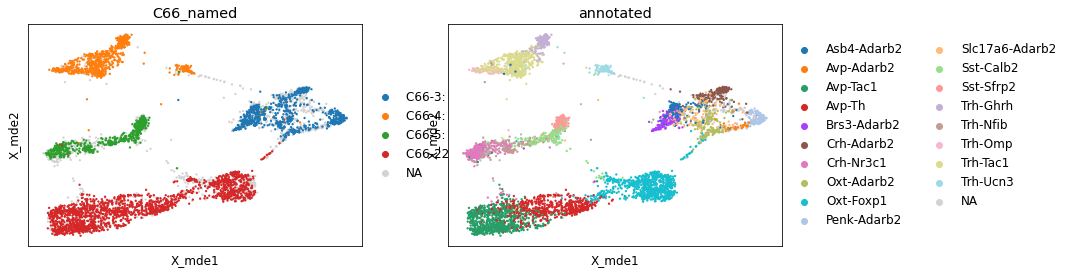

In [10]:
sc.pl.embedding(adata, "X_mde", color = ["C66_named","annotated"])

In [11]:
adata.write_h5ad("Output/Data/2-Integration/4-Final.h5ad")